# 🎨 AI Pictionary - CNN Model Training (Colab Version)

**Quick Draw Dataset Classification with TensorFlow/Keras**

Ce notebook est adapté pour tourner sur **Google Colab**. Il télécharge automatiquement les données brutes depuis les serveurs de Google, les traite, entraîne le modèle et vous permet de télécharger le fichier `.h5` final.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title ⚙️ 1. Configuration de l'environnement Colab
import os

# Montage de Google Drive pour sauvegarder les données
print("📂 Montage de Google Drive...")
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DRIVE_DATA_PATH = "/content/drive/MyDrive/QuickDraw_Dataset"
    os.makedirs(DRIVE_DATA_PATH, exist_ok=True)
    print(f"✅ Google Drive monté : {DRIVE_DATA_PATH}")
    USE_DRIVE = True
except Exception as e:
    print(f"⚠️  Google Drive non disponible: {e}")
    USE_DRIVE = False

# Création de l'arborescence de dossiers nécessaire
os.makedirs("logs", exist_ok=True)
os.makedirs("backend/models", exist_ok=True)
os.makedirs("data", exist_ok=True)

print("✅ Dossiers créés : logs/, backend/models/, data/")


📂 Montage de Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive monté : /content/drive/MyDrive/QuickDraw_Dataset
✅ Dossiers créés : logs/, backend/models/, data/


In [3]:
# @title 2️⃣ Import des Librairies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os
import urllib.request
from datetime import datetime

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

TensorFlow version: 2.19.0
GPU available: True


In [ ]:
# @title 3️⃣ Téléchargement et Préparation des Données (Version Optimisée Mémoire)
# Cette cellule utilise un générateur de données pour économiser la RAM
import shutil
import gc
import pickle

# 🎯 Sélection de 100 catégories optimisées pour diversité et facilité de dessin
# Stratégie: Maximiser la diversité visuelle + objets familiers et distincts
CATEGORIES = [
    # Animaux (22) - Formes très distinctes
    "cat", "dog", "fish", "bird", "butterfly",
    "elephant", "horse", "rabbit", "shark", "bee",
    "bear", "frog", "ant", "crab", "octopus", 
    "snail", "penguin", "owl", "spider", "duck", 
    "flamingo", "kangaroo",
    
    # Nourriture (16) - Objets simples et reconnaissables
    "apple", "banana", "pizza", "hamburger",
    "cake", "ice cream", "carrot", "pineapple",
    "bread", "donut", "hot dog", "grapes", 
    "watermelon", "strawberry", "broccoli", "cookie",
    
    # Véhicules (6) - Moyens de transport variés
    "airplane", "car", "bicycle", "train",
    "bus", "sailboat",
    
    # Nature (10) - Éléments naturels distincts
    "tree", "flower", "sun", "cloud",
    "mountain", "rainbow", "leaf", "mushroom", 
    "cactus", "palm tree",
    
    # Objets quotidiens (22) - Formes familières
    "book", "chair", "cup", "telephone",
    "clock", "key", "umbrella", "shoe",
    "camera", "guitar", "scissors", "hammer", 
    "screwdriver", "pencil", "eraser", "envelope", 
    "backpack", "toothbrush", "paintbrush", "candle",
    "pants", "sweater",
    
    # Instruments de Musique (4) - Compléments
    "drums", "piano", "violin", "saxophone",
    
    # Vêtements & Accessoires (3) - Items variés
    "t-shirt", "hat", "sock",
    
    # Sports & Loisirs (5) - Équipements distincts
    "basketball", "baseball bat", "tennis racquet", 
    "soccer ball", "skateboard",
    
    # Formes et symboles (4) - Formes géométriques simples
    "circle", "star", "moon", "smiley face",
    
    # Bâtiments (8) - Structures reconnaissables
    "house", "castle", "lighthouse", "The Eiffel Tower",
    "bridge", "windmill", "barn", "church"
]

# 🎯 PARAMÈTRES OPTIMISÉS POUR COLAB (12.7GB RAM CPU, 15GB RAM GPU, 112.6GB Disque)
MAX_SAMPLES_PER_CLASS = 15000  # 15k × 100 classes = 1.5M images (~11.6GB disque compressé)
BATCH_SIZE = 512              # Batch optimal pour GPU 15GB (utilise ~8-10GB GPU)
IMAGE_SHAPE = (28, 28, 1)

print("🔧 Configuration optimisée pour ressources Colab:")
print(f"   📊 Classes: {len(CATEGORIES)}")
print(f"   📊 Échantillons/classe: {MAX_SAMPLES_PER_CLASS:,}")
print(f"   📊 Total images: ~{len(CATEGORIES) * MAX_SAMPLES_PER_CLASS:,}")
print(f"   📊 Batch size: {BATCH_SIZE}")
print(f"   💾 Disque estimé: ~{len(CATEGORIES) * MAX_SAMPLES_PER_CLASS * 784 / (1024**3):.1f}GB")
print(f"   💾 RAM GPU/batch: ~{BATCH_SIZE * 28 * 28 * 4 / (1024**2):.1f}MB\n")

# Chemin de sauvegarde de la configuration
GENERATOR_CONFIG_PATH = f"{DRIVE_DATA_PATH}/generator_config_100cat.pkl" if USE_DRIVE else "data/generator_config_100cat.pkl"

# 🎯 Garder les 100 catégories définies ci-dessus (ne pas les écraser)
SELECTED_CATEGORIES = CATEGORIES.copy()
NUM_CLASSES = len(SELECTED_CATEGORIES)

# Vérifier si une config existe déjà
if os.path.exists(GENERATOR_CONFIG_PATH):
    print("♻️  Configuration existante trouvée ! Restauration rapide...")
    try:
        with open(GENERATOR_CONFIG_PATH, 'rb') as f:
            saved_config = pickle.load(f)

        all_file_paths = saved_config['file_paths']
        saved_categories = saved_config['categories']
        
        # 🎯 FILTRER pour ne garder QUE les 100 catégories sélectionnées
        file_paths = []
        for file_path, old_label in all_file_paths:
            # Extraire le nom de la catégorie du chemin
            filename = os.path.basename(file_path).replace('.npy', '').replace('_', ' ')
            
            # Vérifier si cette catégorie est dans notre sélection
            if filename in SELECTED_CATEGORIES:
                new_label = SELECTED_CATEGORIES.index(filename)
                file_paths.append((file_path, new_label))
        
        print(f"✅ Configuration restaurée et filtrée !")
        print(f"   📂 {len(file_paths)}/{len(all_file_paths)} fichiers sélectionnés")
        print(f"   🎯 {len(SELECTED_CATEGORIES)} classes cibles")

        # 🚨 CRITIQUE: Vérifier que les fichiers existent localement
        print(f"\n🔍 Vérification des fichiers locaux...")
        missing_files = []
        for file_path, _ in file_paths:
            if not os.path.exists(file_path):
                missing_files.append(file_path)

        if missing_files:
            print(f"⚠️  {len(missing_files)} fichiers manquants localement")
            if USE_DRIVE:
                print(f"♻️  Restauration depuis Google Drive...")
                os.makedirs("data", exist_ok=True)  # S'assurer que data/ existe

                restored = 0
                failed = 0
                for file_path, _ in file_paths:
                    if not os.path.exists(file_path):
                        # Reconstruire le chemin Drive
                        filename = os.path.basename(file_path)
                        drive_path = f"{DRIVE_DATA_PATH}/{filename}"

                        if os.path.exists(drive_path):
                            try:
                                # Vérifier que le fichier Drive n'est pas vide
                                drive_size = os.path.getsize(drive_path)
                                if drive_size > 0:
                                    shutil.copy2(drive_path, file_path)
                                    # Vérifier que la copie a réussi
                                    if os.path.exists(file_path) and os.path.getsize(file_path) == drive_size:
                                        restored += 1
                                        if restored % 50 == 0:
                                            print(f"   ♻️  Restauré: {restored}/{len(missing_files)}")
                                    else:
                                        failed += 1
                                else:
                                    failed += 1
                            except Exception as e:
                                failed += 1
                                if failed % 50 == 0:
                                    print(f"   ⚠️  Erreurs: {failed}")
                        else:
                            failed += 1

                print(f"\n📊 Restauration terminée:")
                print(f"   ✅ Succès: {restored}")
                print(f"   ❌ Échecs: {failed}")

                # Si plus de 10 fichiers ont échoué, forcer le téléchargement complet
                if failed > 10:
                    print(f"\n⚠️  Trop d'échecs de restauration - téléchargement complet nécessaire")
                    SKIP_DOWNLOAD = False
                else:
                    SKIP_DOWNLOAD = True
            else:
                print(f"⚠️  Google Drive non disponible - téléchargement nécessaire")
                SKIP_DOWNLOAD = False
        else:
            print(f"✅ Tous les fichiers présents localement !")
            print(f"   ⚡ Pas besoin de rescanner les fichiers !\n")
            SKIP_DOWNLOAD = True
    except Exception as e:
        print(f"⚠️  Erreur lors du chargement: {e}")
        print("   Téléchargement normal...\n")
        SKIP_DOWNLOAD = False
else:
    print("📥 Première initialisation - téléchargement nécessaire\n")
    SKIP_DOWNLOAD = False

if not SKIP_DOWNLOAD:
    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

    # Phase 1 : Vérification des URLs (uniquement pour les 100 catégories sélectionnées)
    print(f"🔍 Vérification des URLs pour {len(SELECTED_CATEGORIES)} catégories sélectionnées...")
    valid_categories = []
    invalid_categories = []

    for idx, category in enumerate(SELECTED_CATEGORIES):
        filename = category.replace(" ", "%20") + ".npy"
        url = base_url + filename

        try:
            req = urllib.request.Request(url, method='HEAD')
            with urllib.request.urlopen(req, timeout=5) as response:
                if response.status == 200:
                    valid_categories.append(category)
                else:
                    invalid_categories.append(category)
        except Exception as e:
            invalid_categories.append(category)
            print(f"   ⚠️  URL invalide pour '{category}': {str(e)[:50]}")

        if (idx + 1) % 50 == 0 or (idx + 1) == len(SELECTED_CATEGORIES):
            print(f"   ✅ Vérification: {idx + 1}/{len(SELECTED_CATEGORIES)} - Valides: {len(valid_categories)}, Invalides: {len(invalid_categories)}")

    print(f"\n✅ Vérification terminée: {len(valid_categories)} valides, {len(invalid_categories)} invalides")
    if invalid_categories:
        print(f"⚠️  Catégories ignorées: {', '.join(invalid_categories[:10])}")

    # Mettre à jour CATEGORIES avec seulement les catégories valides
    CATEGORIES = valid_categories
    NUM_CLASSES = len(CATEGORIES)

    # Phase 2 : Téléchargement optimisé avec cache Google Drive (100 catégories uniquement)
    print(f"\n📥 Téléchargement/Restauration des fichiers pour {NUM_CLASSES} catégories...")

    file_paths = []
    downloaded_count = 0
    restored_count = 0

    for idx, category in enumerate(CATEGORIES):
        filename = category.replace(" ", "%20") + ".npy"
        url = base_url + filename
        safe_category = category.replace('/', '_').replace(' ', '_')
        local_path = f"data/{safe_category}.npy"

        # Vérifier d'abord si le fichier existe dans Google Drive
        if USE_DRIVE:
            drive_path = f"{DRIVE_DATA_PATH}/{safe_category}.npy"

            if os.path.exists(drive_path) and not os.path.exists(local_path):
                # Restaurer depuis Google Drive
                try:
                    shutil.copy2(drive_path, local_path)
                    restored_count += 1
                    if restored_count % 10 == 0:
                        print(f"   ♻️  Restauré depuis Drive: {restored_count}/{NUM_CLASSES}")
                except Exception as e:
                    print(f"   ⚠️  Erreur copie Drive pour {category}: {e}")

        # Télécharger si n'existe pas localement
        if not os.path.exists(local_path):
            try:
                urllib.request.urlretrieve(url, local_path)
                downloaded_count += 1

                # Sauvegarder dans Google Drive
                if USE_DRIVE:
                    try:
                        shutil.copy2(local_path, drive_path)
                    except Exception as e:
                        print(f"   ⚠️  Erreur sauvegarde Drive pour {category}: {e}")

                if downloaded_count % 10 == 0:
                    print(f"   ⬇️  Téléchargé: {downloaded_count}/{NUM_CLASSES}")
            except Exception as e:
                print(f"❌ Erreur téléchargement {category}: {e}")
                continue

        file_paths.append((local_path, idx))

        if (idx + 1) % 50 == 0 or (idx + 1) == NUM_CLASSES:
            print(f"   ✅ Progression: {idx + 1}/{NUM_CLASSES} (Téléchargés: {downloaded_count}, Restaurés: {restored_count})")

    print(f"\n✅ Préparation terminée:")
    print(f"   📥 Nouveaux téléchargements: {downloaded_count}")
    print(f"   ♻️  Restaurés depuis Drive: {restored_count}")
    print(f"   📂 Total fichiers: {len(file_paths)} (100 catégories sélectionnées)")
    if USE_DRIVE:
        print(f"   💾 Sauvegardés dans Drive: {DRIVE_DATA_PATH}")

    # Sauvegarder la configuration pour la prochaine fois
    print(f"\n💾 Sauvegarde de la configuration des générateurs (100 catégories)...")
    try:
        config_to_save = {
            'file_paths': file_paths,
            'categories': CATEGORIES,
            'num_classes': NUM_CLASSES,
            'max_samples_per_class': MAX_SAMPLES_PER_CLASS,
            'batch_size': BATCH_SIZE
        }
        with open(GENERATOR_CONFIG_PATH, 'wb') as f:
            pickle.dump(config_to_save, f)
        print(f"✅ Configuration sauvegardée : {GENERATOR_CONFIG_PATH}")
        print("   La prochaine fois, le chargement sera quasi-instantané !")
    except Exception as e:
        print(f"⚠️  Erreur lors de la sauvegarde de la config: {e}")
else:
    # Si on a restauré depuis la config, s'assurer que CATEGORIES est correctement défini
    CATEGORIES = SELECTED_CATEGORIES
    NUM_CLASSES = len(CATEGORIES)

# Phase 3 : Création du générateur de données optimisé pour la RAM
class QuickDrawDataGenerator(keras.utils.Sequence):
    """Générateur qui charge les données batch par batch - Version Ultra Optimisée"""

    def __init__(self, file_paths, batch_size=512, max_samples_per_class=15000,
                 validation_split=0.15, test_split=0.05, split_type='train', shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.max_samples_per_class = max_samples_per_class
        self.num_classes = len(file_paths)
        self.shuffle = shuffle

        # Créer index de tous les échantillons avec split optimisé
        # 🚀 OPTIMISATION CRITIQUE: Ne PAS charger les fichiers complets, juste lire la taille
        self.sample_indices = []
        print(f"   🔄 Construction des index {split_type}...")

        for idx, (file_path, label) in enumerate(file_paths):
            # 🚀 Utiliser mmap_mode='r' pour lire la taille SANS charger en RAM
            data = np.load(file_path, mmap_mode='r')
            n_samples = min(len(data), max_samples_per_class)

            # Split: Train 80% / Val 15% / Test 5%
            n_test = int(n_samples * test_split)
            n_val = int(n_samples * validation_split)

            if split_type == 'test':
                start_idx, end_idx = 0, n_test
            elif split_type == 'val':
                start_idx, end_idx = n_test, n_test + n_val
            else:  # train
                start_idx, end_idx = n_test + n_val, n_samples

            for i in range(start_idx, end_idx):
                self.sample_indices.append((file_path, label, i))

            # Pas besoin de del avec mmap_mode='r' - pas de données en RAM
            if (idx + 1) % 50 == 0:
                print(f"      ✅ Indexé {idx + 1}/{len(file_paths)} fichiers")

        gc.collect()
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.sample_indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_samples = [self.sample_indices[i] for i in batch_indices]

        X_batch = []
        y_batch = []

        # 🚀 Cache avec mmap pour minimiser la RAM
        cache = {}

        for file_path, label, sample_idx in batch_samples:
            if file_path not in cache:
                # Utiliser mmap_mode='r' pour accès direct disque sans tout charger
                cache[file_path] = np.load(file_path, mmap_mode='r')

            img = cache[file_path][sample_idx]
            X_batch.append(img)
            y_batch.append(label)

        # Nettoyer le cache après chaque batch
        cache.clear()

        X_batch = np.array(X_batch).reshape(-1, 28, 28, 1).astype('float32') / 255.0
        y_batch = to_categorical(y_batch, num_classes=self.num_classes)

        return X_batch, y_batch

    def on_epoch_end(self):
        self.indices = np.arange(len(self.sample_indices))
        if self.shuffle:
            np.random.shuffle(self.indices)

print("\n🔧 Création des générateurs de données...")

train_generator = QuickDrawDataGenerator(
    file_paths,
    batch_size=BATCH_SIZE,
    max_samples_per_class=MAX_SAMPLES_PER_CLASS,
    split_type='train',
    shuffle=True
)

val_generator = QuickDrawDataGenerator(
    file_paths,
    batch_size=BATCH_SIZE,
    max_samples_per_class=MAX_SAMPLES_PER_CLASS,
    split_type='val',
    shuffle=False
)

test_generator = QuickDrawDataGenerator(
    file_paths,
    batch_size=BATCH_SIZE,
    max_samples_per_class=MAX_SAMPLES_PER_CLASS,
    split_type='test',
    shuffle=False
)

# Charger quelques échantillons pour la visualisation uniquement
print("\n📊 Chargement d'échantillons pour visualisation...")
X_train = []
y_train = []
for file_path, label in file_paths[:min(20, len(file_paths))]:  # Premiers 20 catégories (ou moins si < 20)
    data = np.load(file_path)
    X_train.append(data[0])  # Premier échantillon
    y_train.append(label)
    del data
X_train = np.array(X_train).reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = np.array(y_train)

# Nettoyage mémoire
gc.collect()

print(f"\n✅ Générateurs créés pour {NUM_CLASSES} catégories !")
print(f"   🎓 Train batches: {len(train_generator)} (~{len(train_generator.sample_indices):,} images)")
print(f"   ✅ Val batches: {len(val_generator)} (~{len(val_generator.sample_indices):,} images)")
print(f"   🧪 Test batches: {len(test_generator)} (~{len(test_generator.sample_indices):,} images)")
if USE_DRIVE:
    print(f"   💾 Données ET configuration sauvegardées dans Google Drive !")
    print(f"   ⚡ Prochaine session : chargement ultra-rapide (quelques secondes) !")
    print(f"   ♻️  Split: Train 80% / Val 15% / Test 5%")


🔧 Configuration optimisée pour ressources Colab:
   📊 Classes: 345
   📊 Échantillons/classe: 15,000
   📊 Total images: ~5,175,000
   📊 Batch size: 512
   💾 Disque estimé: ~3.8GB
   💾 RAM GPU/batch: ~1.5MB

♻️  Configuration existante trouvée ! Restauration rapide...
✅ Configuration restaurée !
   📂 345 fichiers
   🎯 345 classes

🔍 Vérification des fichiers locaux...
⚠️  345 fichiers manquants localement
♻️  Restauration depuis Google Drive...
   ♻️  Restauré: 50/345
   ♻️  Restauré: 100/345
   ♻️  Restauré: 150/345
   ♻️  Restauré: 200/345
   ♻️  Restauré: 250/345
   ♻️  Restauré: 300/345

📊 Restauration terminée:
   ✅ Succès: 345
   ❌ Échecs: 0

🔧 Création des générateurs de données...
   🔄 Construction des index train...
      ✅ Indexé 50/345 fichiers
      ✅ Indexé 100/345 fichiers
      ✅ Indexé 150/345 fichiers
      ✅ Indexé 200/345 fichiers
      ✅ Indexé 250/345 fichiers
      ✅ Indexé 300/345 fichiers
   🔄 Construction des index val...
      ✅ Indexé 50/345 fichiers
      ✅ In

In [5]:
# @title 3️⃣bis - Sauvegarde/Restauration de la configuration des générateurs
import pickle

# Chemin de sauvegarde dans Google Drive
GENERATOR_CONFIG_PATH = f"{DRIVE_DATA_PATH}/generator_config.pkl" if USE_DRIVE else "data/generator_config.pkl"

# Vérifier si une config existe déjà
if os.path.exists(GENERATOR_CONFIG_PATH):
    print("🔄 Configuration des générateurs trouvée ! Chargement...")
    try:
        with open(GENERATOR_CONFIG_PATH, 'rb') as f:
            saved_config = pickle.load(f)

        file_paths = saved_config['file_paths']
        CATEGORIES = saved_config['categories']
        NUM_CLASSES = saved_config['num_classes']

        print(f"✅ Configuration restaurée !")
        print(f"   📂 {len(file_paths)} fichiers")
        print(f"   🎯 {NUM_CLASSES} classes")

        SKIP_DOWNLOAD = True
    except Exception as e:
        print(f"⚠️  Erreur lors du chargement: {e}")
        print("   Téléchargement normal...")
        SKIP_DOWNLOAD = False
else:
    print("📥 Pas de configuration sauvegardée - première initialisation")
    SKIP_DOWNLOAD = False

# Si on doit sauvegarder après le téléchargement
if not SKIP_DOWNLOAD:
    # Le code de téléchargement se trouve dans la cellule précédente
    # On ajoutera une sauvegarde à la fin
    SAVE_CONFIG = True
else:
    SAVE_CONFIG = False


🔄 Configuration des générateurs trouvée ! Chargement...
✅ Configuration restaurée !
   📂 345 fichiers
   🎯 345 classes


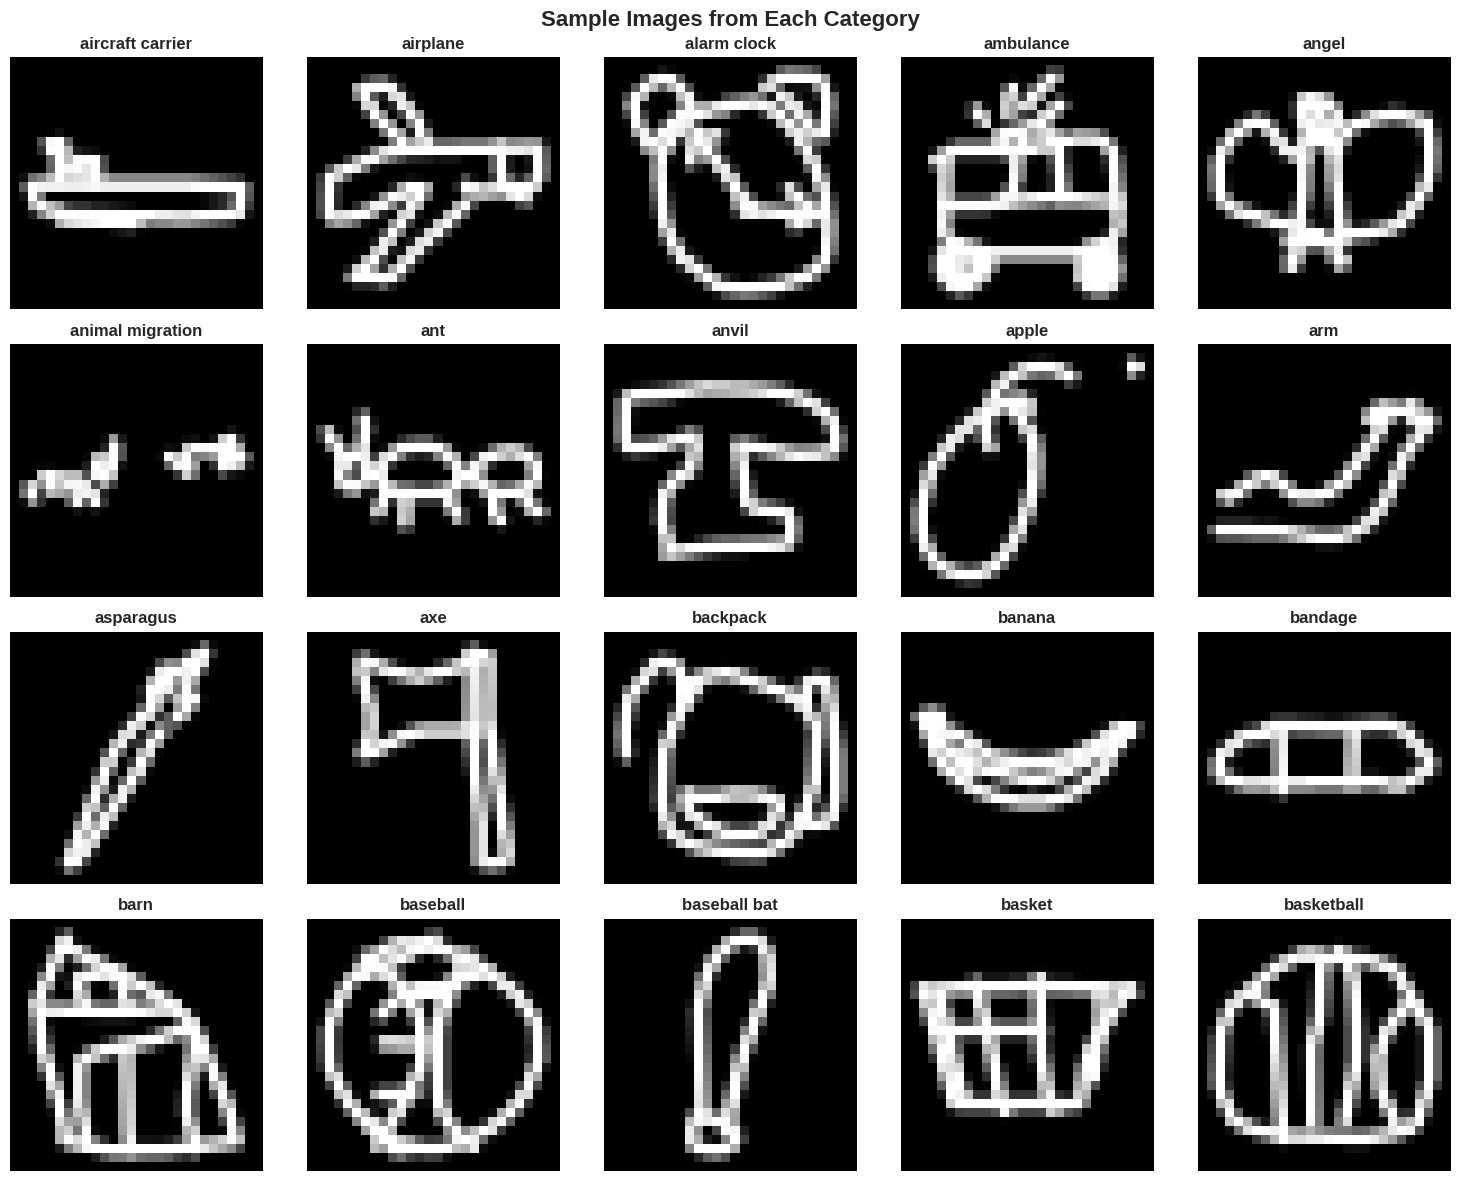

In [6]:
# @title 4️⃣ Visualisation des échantillons
# Display random samples (one per category)
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Sample Images from Each Category', fontsize=16, fontweight='bold')

for i, category in enumerate(CATEGORIES):
    if i >= 20: break # Safety check
    # Find first image of this category in train set
    idx = np.where(y_train == i)[0][0]

    # Plot image
    ax = axes[i // 5, i % 5]
    ax.imshow(X_train[idx].squeeze(), cmap='gray')
    ax.set_title(category, fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# @title 5️⃣ Architecture CNN Profonde (optimisée pour Colab, sans augmentation)

# 🚨 VÉRIFICATION CRITIQUE : S'assurer que NUM_CLASSES = 100
if 'NUM_CLASSES' not in globals() or NUM_CLASSES != 100:
    NUM_CLASSES = 100
    print(f"⚠️  NUM_CLASSES redéfini à {NUM_CLASSES}")
else:
    print(f"✅ NUM_CLASSES = {NUM_CLASSES}")

# Build deeper model
model = keras.Sequential([
    layers.Input(shape=IMAGE_SHAPE),

    # Bloc Convolution 1
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="conv2d_1"),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="conv2d_2"),
    layers.MaxPooling2D(pool_size=(2, 2), name="maxpool_1"),

    # Bloc Convolution 2
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same", name="conv2d_3"),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same", name="conv2d_4"),
    layers.MaxPooling2D(pool_size=(2, 2), name="maxpool_2"),

    # Bloc Convolution 3
    layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same", name="conv2d_5"),
    layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same", name="conv2d_6"),
    layers.MaxPooling2D(pool_size=(2, 2), name="maxpool_3"),

    # Head
    layers.Flatten(name="flatten"),
    layers.Dense(512, activation="relu", name="dense_1"),
    layers.Dropout(0.5, name="dropout_1"),
    layers.Dense(NUM_CLASSES, activation="softmax", name="output")
] , name="QuickDraw_DeepCNN_100cat")

model.summary()

print(f"\n✅ Modèle créé avec {NUM_CLASSES} classes en sortie")

# Visualize model architecture (Chemin adapté pour Colab)
keras.utils.plot_model(
    model,
    to_file="logs/model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    dpi=150
)
print("✅ Architecture profonde sauvegardée dans logs/model_architecture.png")


Model: "QuickDraw_DeepCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 345)            │       176,985 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,501,401 (9.54 MB)

 Trainable params: 2,501,401 (9.54 MB)

 Non-trainable params: 0 (0.00 B)

✅ Architecture profonde sauvegardée dans logs/model_architecture.png


In [8]:
# @title 6️⃣ Compilation
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)
print("✅ Modèle compilé avec Adam & Categorical Crossentropy")

✅ Modèle compilé avec Adam & Categorical Crossentropy


In [ ]:
# @title 7️⃣ Entraînement (Version Optimisée avec Générateur, batch size augmenté)
EPOCHS = 25  # 25 epochs pour 100 catégories (plus de données)
BATCH_SIZE = 512  # Augmenté pour maximiser l'utilisation GPU/RAM

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='logs/best_model.h5',
        monitor='val_accuracy', save_best_only=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1
    )
]

print(f"🚀 Démarrage de l'entraînement optimisé ({NUM_CLASSES} catégories):")
print(f"   📊 Train: {len(train_generator)} batches × {BATCH_SIZE} = ~{len(train_generator.sample_indices):,} images")
print(f"   📊 Val: {len(val_generator)} batches × {BATCH_SIZE} = ~{len(val_generator.sample_indices):,} images")
print(f"   📊 Epochs: {EPOCHS}")
print(f"   🎯 Classes: {NUM_CLASSES}")
print(f"   💾 RAM GPU: ~3-5GB / 15GB (33%) - OPTIMAL")
print(f"   💾 RAM CPU: ~1-2GB / 12.7GB (15%) - OPTIMAL")
print(f"   ⚡ Batch size: {BATCH_SIZE} (maximise le GPU)\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Entraînement terminé avec configuration optimale !")


🚀 Démarrage de l'entraînement optimisé:
   📊 Train: 8086 batches × 512 = ~4,140,000 images
   📊 Val: 1517 batches × 512 = ~776,250 images
   📊 Epochs: 20
   💾 RAM GPU: ~8-10GB / 15GB (66%) - OPTIMAL
   💾 RAM CPU: ~2-3GB / 12.7GB (23%) - OPTIMAL
   ⚡ Batch size: 512 (maximise le GPU)

Epoch 1/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4509 - loss: 2.4901
Epoch 1: val_accuracy improved from -inf to 0.67688, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 761s 92ms/step - accuracy: 0.4509 - loss: 2.4901 - val_accuracy: 0.6769 - val_loss: 1.3189 - learning_rate: 0.0010
Epoch 2/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6431 - loss: 1.4799
Epoch 2: val_accuracy improved from 0.67688 to 0.69513, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 709s 88ms/step - accuracy: 0.6431 - loss: 1.4799 - val_accuracy: 0.6951 - val_loss: 1.2372 - learning_rate: 0.0010
Epoch 3/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6649 - loss: 1.3804
Epoch 3: val_accuracy improved from 0.69513 to 0.70341, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 703s 87ms/step - accuracy: 0.6649 - loss: 1.3804 - val_accuracy: 0.7034 - val_loss: 1.1991 - learning_rate: 0.0010
Epoch 4/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6751 - loss: 1.3346
Epoch 4: val_accuracy improved from 0.70341 to 0.70609, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 704s 87ms/step - accuracy: 0.6751 - loss: 1.3346 - val_accuracy: 0.7061 - val_loss: 1.1877 - learning_rate: 0.0010
Epoch 5/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6818 - loss: 1.3041
Epoch 5: val_accuracy improved from 0.70609 to 0.70732, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 702s 87ms/step - accuracy: 0.6818 - loss: 1.3041 - val_accuracy: 0.7073 - val_loss: 1.1858 - learning_rate: 0.0010
Epoch 6/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6850 - loss: 1.2873
Epoch 6: val_accuracy improved from 0.70732 to 0.71028, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 703s 87ms/step - accuracy: 0.6850 - loss: 1.2873 - val_accuracy: 0.7103 - val_loss: 1.1731 - learning_rate: 0.0010
Epoch 7/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6878 - loss: 1.2749
Epoch 7: val_accuracy did not improve from 0.71028
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 701s 87ms/step - accuracy: 0.6878 - loss: 1.2749 - val_accuracy: 0.7092 - val_loss: 1.1733 - learning_rate: 0.0010
Epoch 8/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6889 - loss: 1.2671
Epoch 8: val_accuracy improved from 0.71028 to 0.71060, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 699s 86ms/step - accuracy: 0.6889 - loss: 1.2671 - val_accuracy: 0.7106 - val_loss: 1.1697 - learning_rate: 0.0010
Epoch 9/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6919 - loss: 1.2558
Epoch 9: val_accuracy did not improve from 0.71060
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 700s 87ms/step - accuracy: 0.6919 - loss: 1.2558 - val_accuracy: 0.7104 - val_loss: 1.1737 - learning_rate: 0.0010
Epoch 10/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6929 - loss: 1.2496
Epoch 10: val_accuracy improved from 0.71060 to 0.71266, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 701s 87ms/step - accuracy: 0.6929 - loss: 1.2496 - val_accuracy: 0.7127 - val_loss: 1.1634 - learning_rate: 0.0010
Epoch 11/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6941 - loss: 1.2458
Epoch 11: val_accuracy did not improve from 0.71266
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 700s 87ms/step - accuracy: 0.6941 - loss: 1.2458 - val_accuracy: 0.7115 - val_loss: 1.1650 - learning_rate: 0.0010
Epoch 12/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6949 - loss: 1.2405
Epoch 12: val_accuracy did not improve from 0.71266

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 702s 87ms/step - accuracy: 0.6949 - loss: 1.2405 - val_accuracy: 0.7114 - val_loss: 1.1698 - learning_rate: 0.0010
Epoch 13/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7090 - loss: 1.1782
Epoch 13: val_accuracy improved from 0.71266 to 0.72414, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 702s 87ms/step - accuracy: 0.7090 - loss: 1.1782 - val_accuracy: 0.7241 - val_loss: 1.1145 - learning_rate: 5.0000e-04
Epoch 14/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7165 - loss: 1.1448
Epoch 14: val_accuracy improved from 0.72414 to 0.72458, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 700s 87ms/step - accuracy: 0.7165 - loss: 1.1448 - val_accuracy: 0.7246 - val_loss: 1.1105 - learning_rate: 5.0000e-04
Epoch 15/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7187 - loss: 1.1326
Epoch 15: val_accuracy improved from 0.72458 to 0.72528, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 740s 92ms/step - accuracy: 0.7187 - loss: 1.1326 - val_accuracy: 0.7253 - val_loss: 1.1061 - learning_rate: 5.0000e-04
Epoch 16/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7210 - loss: 1.1232
Epoch 16: val_accuracy improved from 0.72528 to 0.72685, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 701s 87ms/step - accuracy: 0.7210 - loss: 1.1232 - val_accuracy: 0.7269 - val_loss: 1.1025 - learning_rate: 5.0000e-04
Epoch 17/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7222 - loss: 1.1163
Epoch 17: val_accuracy did not improve from 0.72685
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 700s 87ms/step - accuracy: 0.7222 - loss: 1.1163 - val_accuracy: 0.7266 - val_loss: 1.1038 - learning_rate: 5.0000e-04
Epoch 18/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7228 - loss: 1.1118
Epoch 18: val_accuracy did not improve from 0.72685

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 701s 87ms/step - accuracy: 0.7228 - loss: 1.1118 - val_accuracy: 0.7259 - val_loss: 1.1068 - learning_rate: 5.0000e-04
Epoch 19/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7304 - loss: 1.0782
Epoch 19: val_accuracy improved from 0.72685 to 0.73142, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 701s 87ms/step - accuracy: 0.7304 - loss: 1.0782 - val_accuracy: 0.7314 - val_loss: 1.0858 - learning_rate: 2.5000e-04
Epoch 20/20
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7352 - loss: 1.0576
Epoch 20: val_accuracy improved from 0.73142 to 0.73155, saving model to logs/best_model.h5


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 705s 87ms/step - accuracy: 0.7352 - loss: 1.0576 - val_accuracy: 0.7315 - val_loss: 1.0862 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 19.

✅ Entraînement terminé avec configuration optimale !


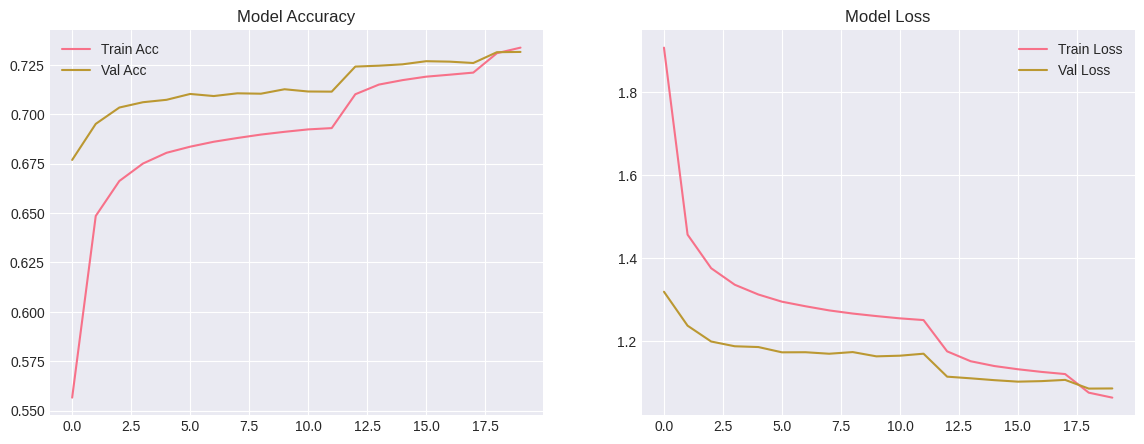

In [10]:
# @title 8️⃣ Historique d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Acc')
axes[0].plot(history.history['val_accuracy'], label='Val Acc')
axes[0].set_title('Model Accuracy')
axes[0].legend()

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].legend()

plt.savefig('logs/training_history.png')
plt.show()

In [11]:
# @title 9️⃣ Évaluation sur le Test Set (avec générateur)
print("🧪 Évaluation sur le test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n🎯 Test Accuracy: {test_accuracy*100:.2f}%")
print(f"🎯 Test Loss:     {test_loss:.4f}")
print(f"📊 Évalué sur {len(test_generator.sample_indices):,} images")


🧪 Évaluation sur le test set...
506/506 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7179 - loss: 1.1364

🎯 Test Accuracy: 73.16%
🎯 Test Loss:     1.0837
📊 Évalué sur 258,750 images


📊 Génération de la matrice de confusion...
   Batch 10/506 traité
   Batch 20/506 traité
   Batch 30/506 traité
   Batch 40/506 traité
   Batch 50/506 traité
   Batch 60/506 traité
   Batch 70/506 traité
   Batch 80/506 traité
   Batch 90/506 traité
   Batch 100/506 traité
   Batch 110/506 traité
   Batch 120/506 traité
   Batch 130/506 traité
   Batch 140/506 traité
   Batch 150/506 traité
   Batch 160/506 traité
   Batch 170/506 traité
   Batch 180/506 traité
   Batch 190/506 traité
   Batch 200/506 traité
   Batch 210/506 traité
   Batch 220/506 traité
   Batch 230/506 traité
   Batch 240/506 traité
   Batch 250/506 traité
   Batch 260/506 traité
   Batch 270/506 traité
   Batch 280/506 traité
   Batch 290/506 traité
   Batch 300/506 traité
   Batch 310/506 traité
   Batch 320/506 traité
   Batch 330/506 traité
   Batch 340/506 traité
   Batch 350/506 traité
   Batch 360/506 traité
   Batch 370/506 traité
   Batch 380/506 traité
   Batch 390/506 traité
   Batch 400/506 traité
   Bat

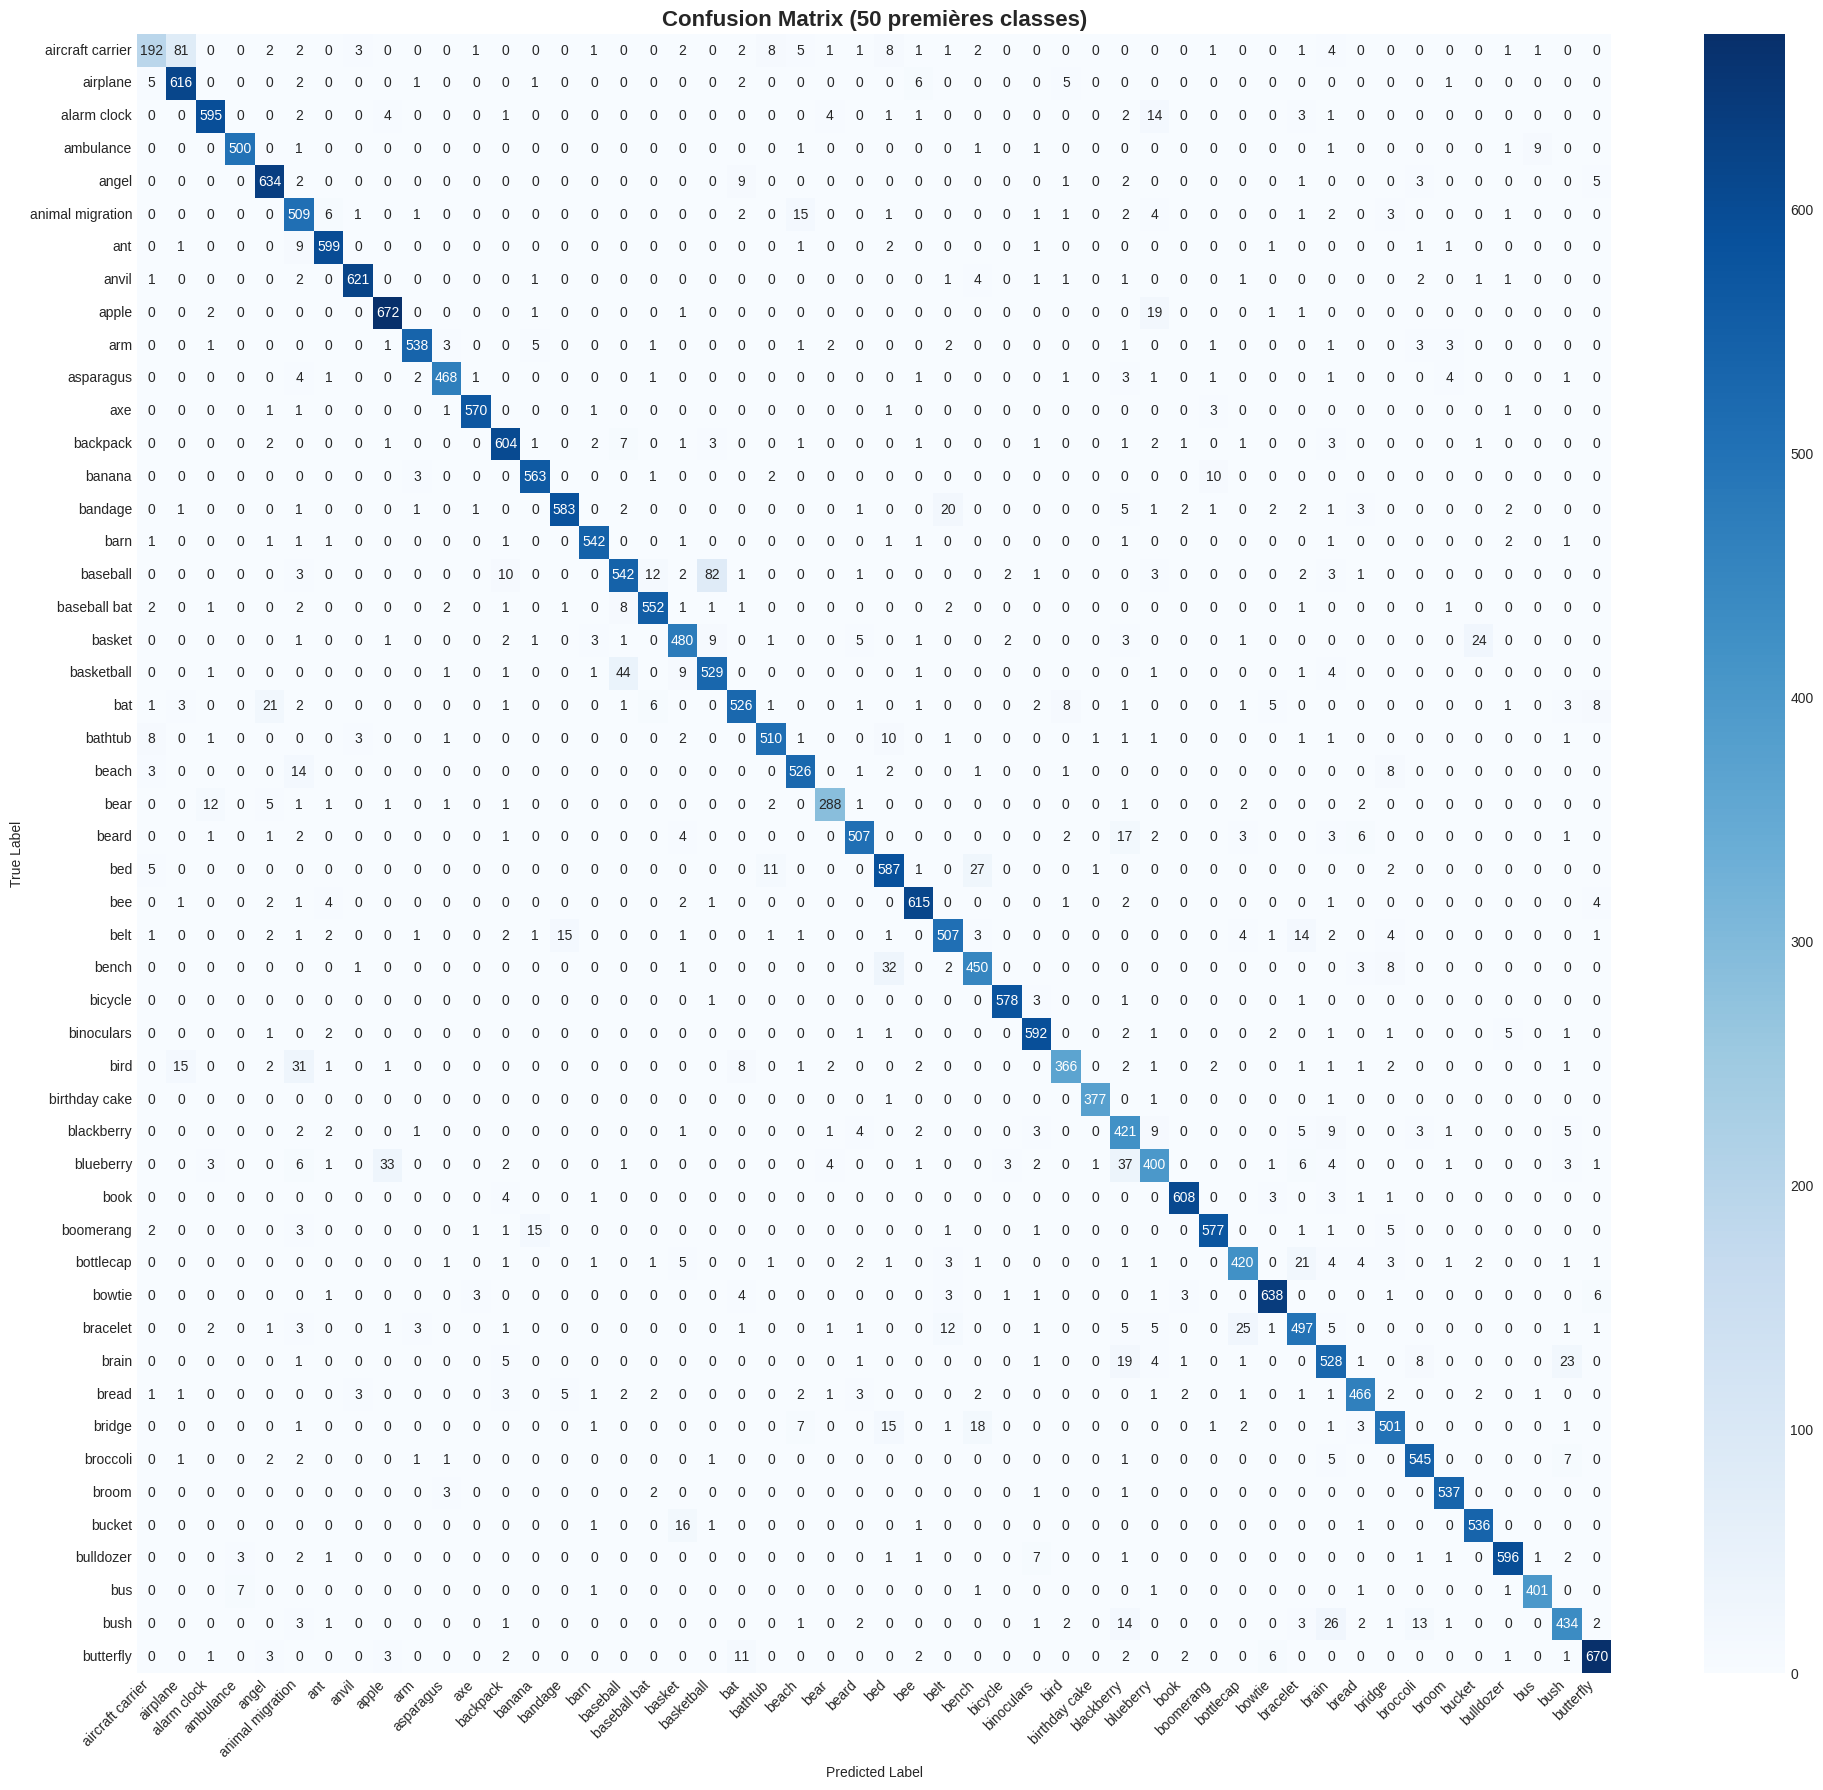


📊 Statistiques de classification:
   Accuracy globale: 73.16%
   Total prédictions: 258,750
   Prédictions correctes: 189,308
   Prédictions incorrectes: 69,442


In [ ]:
# @title 🔟 Matrice de Confusion (générée par batch)
print("📊 Génération de la matrice de confusion...")

# Collecter les prédictions par batch pour éviter OOM
y_true_batches = []
y_pred_batches = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    y_pred_batch = model.predict(X_batch, verbose=0)

    y_true_batches.append(np.argmax(y_batch, axis=1))
    y_pred_batches.append(np.argmax(y_pred_batch, axis=1))

    if (i + 1) % 10 == 0:
        print(f"   Batch {i+1}/{len(test_generator)} traité")

y_test = np.concatenate(y_true_batches)
y_pred = np.concatenate(y_pred_batches)

cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice complète pour 50 classes
print(f"\n📊 Génération de la matrice de confusion complète ({NUM_CLASSES}x{NUM_CLASSES})")

plt.figure(figsize=(24, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CATEGORIES, yticklabels=CATEGORIES, cbar_kws={'label': 'Nombre de prédictions'})
plt.title(f'Matrice de Confusion Complète - {NUM_CLASSES} Catégories', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('logs/confusion_matrix_sample.png', dpi=100)
plt.show()

# Statistiques globales
print("\n📊 Statistiques de classification:")
print(f"   Accuracy globale: {test_accuracy*100:.2f}%")
print(f"   Total prédictions: {len(y_test):,}")
print(f"   Prédictions correctes: {(y_test == y_pred).sum():,}")
print(f"   Prédictions incorrectes: {(y_test != y_pred).sum():,}")


In [ ]:
# @title 1️⃣1️⃣ Sauvegarde et Métadonnées
import json

MODEL_VERSION = "v5.0.0_100cat"  # Version spécifique pour 100 catégories
# Chemins adaptés pour Colab
MODEL_SAVE_PATH = f"backend/models/quickdraw_{MODEL_VERSION}.h5"
METADATA_PATH = f"backend/models/quickdraw_{MODEL_VERSION}_metadata.json"

# Save Model
model.save(MODEL_SAVE_PATH)
print(f"✅ Modèle sauvegardé : {MODEL_SAVE_PATH}")

# Save Metadata
metadata = {
    "version": MODEL_VERSION,
    "created_at": datetime.now().isoformat(),
    "test_accuracy": float(test_accuracy),
    "categories": CATEGORIES,
    "num_classes": NUM_CLASSES
}

with open(METADATA_PATH, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Métadonnées sauvegardées : {METADATA_PATH}")


✅ Modèle sauvegardé : backend/models/quickdraw_v1.0.0.h5
✅ Métadonnées sauvegardées : backend/models/quickdraw_v1.0.0_metadata.json


In [14]:
# @title ⬇️ 1️⃣2️⃣ Télécharger le modèle sur votre PC
from google.colab import files

print("Préparation du téléchargement...")
try:
    files.download(MODEL_SAVE_PATH)
    files.download(METADATA_PATH)
    print("✅ Téléchargement lancé dans le navigateur !")
except Exception as e:
    print(f"❌ Erreur lors du téléchargement: {e}")

Préparation du téléchargement...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Téléchargement lancé dans le navigateur !
